# Image rotations

![](../img/rotation.gif "spinnnnnnnnnnnnn")

# Steps

1. Setup
2. Basics
3. Get image slice
4. Orientation
5. Rotations

# Setup

In [3]:

# Image processing
import SimpleITK as sitk
import numpy as np

# Image rendering
import matplotlib.pyplot as plt

%matplotlib inline
from ipywidgets import interact, fixed

# Miscellaneous
from pprint import pprint
from rotations_helpers import (degrees_to_radians, disp_slice,
                               resample_2d_rotation, resample_3d_rotation, View,
                               get_center_of_rotation)

# Read image using `sitk.ImageFileReader`

[List of extensions supported](https://simpleitk.readthedocs.io/en/master/IO.html)

In [4]:

READER: sitk.ImageFileReader = sitk.ImageFileReader()

# We need only give ImageFileReader a file path.
# It will automatically detect the file type.
READER.SetFileName("../ExampleData/MicroBiome_1month_T1w.nii.gz")
img_3d: sitk.Image = READER.Execute()

# Display the middle z slice

Here, we have to convert the `sitk.Image` to a `numpy` array for rendering.

(-0.5, 243.5, 291.5, -0.5)

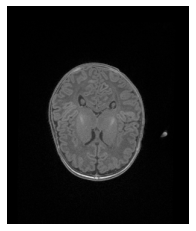

In [5]:

SIZE = img_3d.GetSize()
z_center: int = (SIZE[2] - 1) // 2
slice_middle_z: sitk.Image = img_3d[:, :, z_center]

# Convert sitk.Image to numpy array for rendering
slice_np: np.ndarray = sitk.GetArrayFromImage(slice_middle_z)
plt.imshow(slice_np, cmap="gray")
plt.axis("off")

# SimpleITK and numpy use [opposite orders for indexing](https://simpleitk.org/SPIE2019_COURSE/02_images_and_resampling.html#SimpleITK2Numpy-and-Numpy2SimpleITK)!

SimpleITK: `[x, y, z]`

numpy: `[z, y, x]`

In [6]:

print(f"sitk.Image dimensions: {SIZE}")
img_3d_np: np.ndarray = sitk.GetArrayFromImage(img_3d)
print(f"ndarray dimensions: {img_3d_np.shape}")

for x in range(0, SIZE[0], 25):
    for y in range(0, SIZE[1], 25):
        for z in range(0, SIZE[2], 25):
            assert img_3d.GetPixel(x, y, z) == img_3d_np[z][y][x]

sitk.Image dimensions: (244, 292, 198)
ndarray dimensions: (198, 292, 244)


# Try displaying middle x and y slices

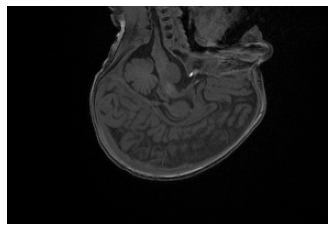

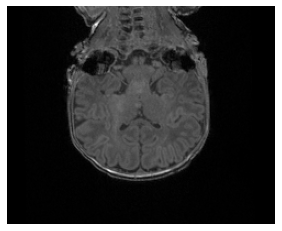

In [7]:

x_center: int = (SIZE[0] - 1) // 2
y_center: int = (SIZE[1] - 1) // 2

disp_slice(img_3d[x_center, :, :])
disp_slice(img_3d[:, y_center, :])

# Misoriented... orient the image to follow [ITK-SNAP](http://www.itksnap.org) radiological conventions (shown in screenshot)

Let's orient this image for the **axial view** using the [`DICOMOrientImageFilter`](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DICOMOrientImageFilter.html#details).

`DICOMOrientImageFilter` can orient any image, even a misaligned one such as `ExampleData/IBIS_Dataset_NotAligned_6month_T1w.nrrd`, for all 3 views such that the views look like this:

![NIfTI image in ITK-SNAP](https://i.imgur.com/ZTZ2icP.png)

Axial


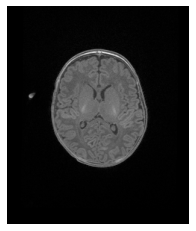

In [8]:

# From https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DICOMOrientImageFilter.html#details
ORIENT_FILTER: sitk.DICOMOrientImageFilter = sitk.DICOMOrientImageFilter()
AXIAL_ORIENTATION_STR = "LPS"
ORIENT_FILTER.SetDesiredCoordinateOrientation(AXIAL_ORIENTATION_STR)

img_3d_axial: sitk.Image = ORIENT_FILTER.Execute(img_3d)
slice_axial: sitk.Image = img_3d_axial[:, :, z_center]

print("Axial")
disp_slice(slice_axial)

# Orient for sagittal and coronal views

Sagittal


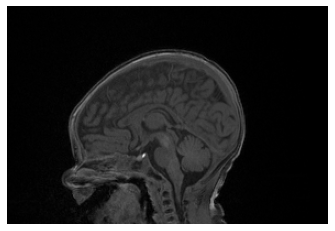

Coronal


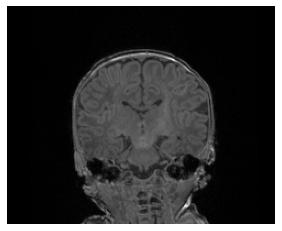

In [9]:

SAGITTAL_ORIENTATION_STR: str = "RPI"
CORONAL_ORIENTATION_STR: str = "LPI"

ORIENT_FILTER.SetDesiredCoordinateOrientation(SAGITTAL_ORIENTATION_STR)
img_3d_sagittal: sitk.Image = ORIENT_FILTER.Execute(img_3d)

ORIENT_FILTER.SetDesiredCoordinateOrientation(CORONAL_ORIENTATION_STR)
img_3d_coronal: sitk.Image = ORIENT_FILTER.Execute(img_3d)

print("Sagittal")
disp_slice(img_3d_sagittal[x_center, :, :])
print("Coronal")
disp_slice(img_3d_coronal[:, y_center, :])

# 2D rotation using `Euler2DTransform`

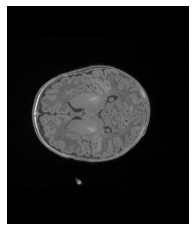

In [10]:

# Initialize 2D rotation transform object with center of rotation
# get_center_of_rotation just divides dimensions by 2
euler_2d_transform: sitk.Euler2DTransform = sitk.Euler2DTransform(
    get_center_of_rotation(slice_axial)
)
euler_2d_transform.SetAngle(degrees_to_radians(90))

rotated_slice: sitk.Image = sitk.Resample(slice_axial, euler_2d_transform)
disp_slice(rotated_slice)


# Interactive 2D rotation

In [11]:

interact(
    resample_2d_rotation,
    img_2d=fixed(slice_axial),
    euler_2d_transform = fixed(euler_2d_transform),
    θ=(-90, 90)
)

interactive(children=(IntSlider(value=0, description='θ', max=90, min=-90), Output()), _dom_classes=('widget-i…

<function rotations_helpers.resample_2d_rotation(img_2d: SimpleITK.SimpleITK.Image, euler_2d_transform: SimpleITK.SimpleITK.Euler2DTransform, θ: int) -> None>

# 3D rotation using `Euler3DTransform`

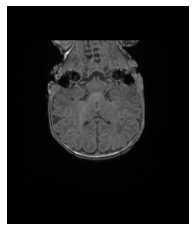

In [12]:

euler_3d_transform: sitk.Euler3DTransform = sitk.Euler3DTransform(get_center_of_rotation(img_3d_axial))
euler_3d_transform.SetRotation(degrees_to_radians(90), degrees_to_radians(90), degrees_to_radians(90))

rotated_3d: sitk.Image = sitk.Resample(img_3d_axial, euler_3d_transform)
rotated_slice: sitk.Image = rotated_3d[:, :, z_center]
disp_slice(rotated_slice)


# Interactive 3D rotations for all views

In [13]:

print("Sagittal")
interact(
    resample_3d_rotation,
    img_3d=fixed(img_3d_sagittal),
    euler_3d_transform = fixed(euler_3d_transform),
    θ_x=(-90, 90),
    θ_y=(-90, 90),
    θ_z=(-90, 90),
    slice=(0, img_3d_axial.GetSize()[View.X.value]-1),
    view=fixed(View.X)
)

print("Coronal")
interact(
    resample_3d_rotation,
    img_3d=fixed(img_3d_coronal),
    euler_3d_transform = fixed(euler_3d_transform),
    θ_x=(-90, 90),
    θ_y=(-90, 90),
    θ_z=(-90, 90),
    slice=(0, img_3d_axial.GetSize()[View.Y.value]-1),
    view=fixed(View.Y)
)

print("Axial")
interact(
    resample_3d_rotation,
    img_3d=fixed(img_3d_axial),
    euler_3d_transform = fixed(euler_3d_transform),
    θ_x=(-90, 90),
    θ_y=(-90, 90),
    θ_z=(-90, 90),
    slice=(0, img_3d_axial.GetSize()[View.Z.value]-1),
    view=fixed(View.Z)
)

Sagittal


interactive(children=(IntSlider(value=0, description='θ_x', max=90, min=-90), IntSlider(value=0, description='…

Coronal


interactive(children=(IntSlider(value=0, description='θ_x', max=90, min=-90), IntSlider(value=0, description='…

Axial


interactive(children=(IntSlider(value=0, description='θ_x', max=90, min=-90), IntSlider(value=0, description='…

<function rotations_helpers.resample_3d_rotation(img_3d: SimpleITK.SimpleITK.Image, euler_3d_transform: SimpleITK.SimpleITK.Euler3DTransform, θ_x: int, θ_y: int, θ_z: int, slice: int, view: rotations_helpers.View) -> None>